In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
import requests
%pip install fredapi
from fredapi import Fred #package for pulling from FRED API

ModuleNotFoundError: No module named 'numpy'

Section 1: Pulls desired economic data series from FRED API

In [ ]:
fred = Fred(api_key = "ef5451a7d8f6d761a7f3fb042aebd7da") 
# my API Key, careful with it I guess.
# this is a fucntion the uses fredapi packages to easily retrive series

In [ ]:
def get_fred (series_code: str):
    '''
    Pulls data from FRED API in the form of a series and returns cleaned 
    data set
    
    parameter
    --------
    sereies_code: Code for specific data sereis complied on FRED website 
    
    returns:
    --------
    dataframe: a dataframe of the FRED metric according to the data series
    given to the function
    '''
    fred = Fred(api_key = "ef5451a7d8f6d761a7f3fb042aebd7da")
    
    data = fred.get_series(f"{series_code}")
    dataframe = pd.DataFrame(data)
    data_rn = {0 : f"{series_code}"}
    cleaned = dataframe.rename(data_rn, axis=1)
    cleaned = cleaned.reset_index()
    a = {"index": "Date"}
    cleaned = cleaned.rename(a, axis = 1)
    cleaned["Date"] = pd.to_datetime(cleaned["Date"])
    return cleaned

Below use the get_fred fucntion to obatin the desiresed series that will be cleaned and put into a data set.

In [ ]:
unemp = get_fred("UNRATE") # unemplyment rate, by month
#unemp
GDP = get_fred("GDPC1") #nominal, by quater, real gdp
#GDP
consumer_sent = get_fred("UMCSENT") # U Mich consumer sentiment, by month
#consumer_sent
debt_income = get_fred("TDSP") #total debt service to income ratio, by quater
#debt_income
gdp_capita = get_fred("A939RX0Q048SBEA") #real ratio, by quater 
#gdp_capita
gas_prices = get_fred("GASREGCOVW") #national gas price average, by week
#gas_prices
inflation = get_fred("FPCPITOTLZGUSA") #inflation rate, by year
#inflation
PCE = get_fred("DPCERD3Q086SBEA") #PCE with index set to 2012, quarterly
#PCE

Renaming the series to be more legible and useable.

In [ ]:
j = {"GDPC1" : "GDP"}
GDP = GDP.rename(j, axis=1)
#GDP

In [ ]:
p = {"DPCERD3Q086SBEA": "PCE"}
PCE = PCE.rename(p, axis =1 )
#PCE

In [ ]:
i = {"FPCPITOTLZGUSA" : "inflat_index"}
inflation = inflation.rename(i, axis=1)
#inflation

In [ ]:
gas = {"GASREGCOVW" : "gas_price"}
gas_prices = gas_prices.rename(gas, axis=1)
gas_prices = (gas_prices.set_index("Date").
              resample("MS").mean().
              reset_index())
#gas_prices

In [ ]:
jeff = {"A939RX0Q048SBEA" : "gdp_per_capita"}
gdp_capita = gdp_capita.rename(jeff, axis=1)
#GDP_per_capita

In [ ]:
debt_pct_income = {"TDSP" : "debt_pct_income"}
debt_income = debt_income.rename(debt_pct_income, axis=1)
#Debt_Payment

In [ ]:
Consum_Sent = {"UMCSENT" : "consum_sent"}
consumer_sent = consumer_sent.rename(Consum_Sent, axis=1)
#consumer_sent

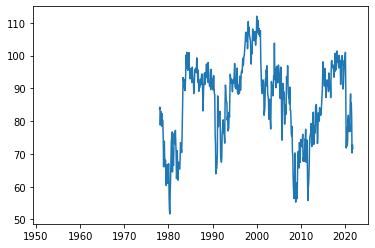

In [ ]:
plt.plot(consumer_sent.Date, consumer_sent.consum_sent)

In [ ]:
data_month = gas_prices.merge(
    unemp.merge(
    consumer_sent, on="Date", how="outer"))
#data_month.head(10)

In [ ]:
# Pulling in Data From Box Office Mojo

In [ ]:
data_qrt = data_month.set_index("Date").resample("QS").mean().reset_index()
#data_qrt.head(10)

In [ ]:
data_qrt = data_qrt.merge(
    GDP.merge(
    gdp_capita.merge(
    PCE.merge(
    debt_income, on="Date", how = "outer"))))
#data_qrt.head(10)


In [ ]:
def get_table(url):
    '''
    Function gets the datatable requesuted from the boxoffice mojo
    url and outputs to a dataframe
    '''
    response = requests.get(url).content
    table = pd.read_html(response)
    table_df = pd.DataFrame(table[-1])
    return table_df

In [ ]:
url = "https://www.boxofficemojo.com/year/?ref_=bo_nb_ml_secondarytab"
box_year = get_table(url)
#box_year

In [ ]:
box_jan = get_table("https://www.boxofficemojo.com/month/january/?grossesOption=calendarGrosses")
box_feb = get_table("https://www.boxofficemojo.com/month/february/?grossesOption=calendarGrosses")
box_mar = get_table("https://www.boxofficemojo.com/month/march/?grossesOption=calendarGrosses")
box_apr = get_table("https://www.boxofficemojo.com/month/april/?grossesOption=calendarGrosses")
box_may = get_table("https://www.boxofficemojo.com/month/may/?grossesOption=calendarGrosses")
box_jun = get_table("https://www.boxofficemojo.com/month/june/?grossesOption=calendarGrosses")
box_jul = get_table("https://www.boxofficemojo.com/month/july/?grossesOption=calendarGrosses")
box_aug = get_table("https://www.boxofficemojo.com/month/august/?grossesOption=calendarGrosses")
box_sep = get_table("https://www.boxofficemojo.com/month/september/?grossesOption=calendarGrosses")
box_oct = get_table("https://www.boxofficemojo.com/month/october/?grossesOption=calendarGrosses")
box_nov = get_table("https://www.boxofficemojo.com/month/november/?grossesOption=calendarGrosses")
box_dec = get_table("https://www.boxofficemojo.com/month/december/?grossesOption=calendarGrosses")

In [ ]:
#box_feb

In [ ]:
def reduce_table(df, month: int):
    jeff = df.drop(['%± LY', '#1 Release', 'Gross','% of Total',
                    'Genre', 'Budget', 'Running Time'], axis=1)
    jeff["month"] = month
    jeff["Date"]= pd.to_datetime(jeff[['Year', 'month']].assign(DAY=1))
    return jeff

In [ ]:
box_jan = reduce_table(box_jan,1)
box_feb = reduce_table(box_feb,2)
box_mar = reduce_table(box_mar,3)
box_apr = reduce_table(box_apr,4)
box_may = reduce_table(box_may,5)
box_jun = reduce_table(box_jun,6)
box_jul = reduce_table(box_jul,7)
box_aug = reduce_table(box_aug,8)
box_sep = reduce_table(box_sep,9)
box_oct = reduce_table(box_oct,10)
box_nov = reduce_table(box_nov,11)
box_dec = reduce_table(box_dec,12)

In [ ]:
box_office = (pd.concat([box_jan,box_feb,box_mar,box_apr,box_may,box_jun,
                        box_jul,box_aug,box_sep, box_oct, box_nov, box_dec],
                       axis = 0)
              .sort_values(by=["Date"])
              .set_index("Date")
              .drop(["Year",'month'], axis=1))
box_office["gross"] = (box_office["Cumulative Gross"]
                                  .str.replace("$", "")
                                  .str.replace(",", "")
                                  .astype(int))

box_office_month = box_office.copy()
box_office_month.head()

,Cumulative Gross,Releases,Average,gross
Date,,,,
1972-03-01,"$133,698,921",1,"$133,698,921",133698921
1972-12-01,"$84,563,118",1,"$84,563,118",84563118
1975-06-01,"$23,565,886",1,"$23,565,886",23565886
1975-07-01,"$46,159,490",1,"$46,159,490",46159490
1975-11-01,"$190,274,624",1,"$190,274,624",190274624


In [ ]:
box_office_qrt = box_office.resample("QS").sum()
box_office_qrt = box_office_qrt.reset_index()

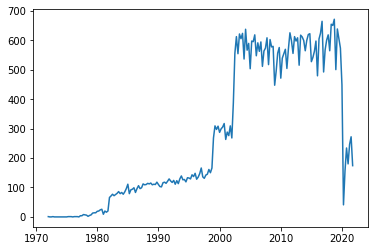

In [ ]:
plt.plot(box_office_qrt.Date,box_office_qrt.Releases)

In [ ]:
data_qrt = data_qrt.merge(box_office_qrt, on="Date", how="outer")
# to account for inflation in the data to 2012 index
data_qrt["PCE"] = data_qrt["PCE"] * .01
data_qrt["gas_price"] = data_qrt["gas_price"]/data_qrt["PCE"]
data_qrt["gross"] = data_qrt["gross"]/data_qrt["PCE"]
data_qrt.head()

,Date,gas_price,UNRATE,consum_sent,GDP,gdp_per_capita,PCE,debt_pct_income,Releases,gross
0,1990-01-01,NaN,5.300000,91.266667,9364.259,37617.0,0.62198,11.649150,110,1.479302e+09
1,1990-04-01,NaN,5.333333,90.933333,9398.243,37636.0,0.62764,11.600660,103,1.709974e+09
2,1990-07-01,1.947705,5.700000,79.133333,9404.494,37529.0,0.63562,11.583131,102,2.047944e+09
3,1990-10-01,2.070536,6.133333,65.133333,9318.876,37056.0,0.64402,11.604449,116,1.602071e+09
4,1991-01-01,1.706441,6.600000,74.966667,9275.276,36769.0,0.64740,11.578032,118,1.806037e+09


In [ ]:
# original data cleaning

In [ ]:
url = "https://datasets.imdbws.com/title.basics.tsv.gz"
df = pd.read_csv(url, sep='\t')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
url_1 = "https://datasets.imdbws.com/title.ratings.tsv.gz"
df_ratings = pd.read_csv("https://datasets.imdbws.com/title.ratings.tsv.gz", sep= '\t')

In [ ]:
df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [ ]:
df=pd.DataFrame(df)
print(df["titleType"].unique())
df = df.query("titleType == 'movie' & isAdult == 0")

['short' 'movie' 'tvEpisode' 'tvSeries' 'tvShort' 'tvMovie' 'tvMiniSeries'
 'tvSpecial' 'video' 'videoGame' 'tvPilot']


In [ ]:
df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
610,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama
625,tt0000630,movie,Hamlet,Amleto,0,1908,\N,\N,Drama


In [ ]:
df_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1841
1,tt0000002,6.0,236
2,tt0000003,6.5,1603
3,tt0000004,6.0,153
4,tt0000005,6.2,2422


In [ ]:
movies = df[["tconst","startYear",]]
movies.head()

,tconst,startYear
498,tt0000502,1905
570,tt0000574,1906
587,tt0000591,1907
610,tt0000615,1907
625,tt0000630,1908


In [ ]:
movies["startYear"].unique()

array([1905, 1906, 1907, 1908, 1909, 1910, 1912, 1911, 1913, 1915, 1914,
       1919, 1916, 1917, 1936, 1925, 1918, 1920, 1922, 1921, 2019, 1924,
       1923, 1928, 1926, 1927, 1929, 2000, 1993, 1935, 2014, 1930, 1942,
       1932, 1931, 1934, 1939, 1937, 1933, 1950, 1938, 1951, 1946, 1996,
       1940, 1944, 1947, 1941, 1952, 1970, 1957, 1943, 1948, 1945, 2001,
       1949, 1953, 2008, 1954, 1965, 1983, 1980, 1973, 1961, 1955, 1962,
       1958, 1956, 1977, 1964, 1967, 1960, 1959, 1968, 1963, 1971, 1969,
       1972, 1966, 1976, 1990, 1979, 1981, 2020, 1975, 1978, 1989, 1974,
       1986, '1971', '1972', '1970', '1974', '1973', '1976', '1969',
       '1981', '1968', '1985', '1986', '1987', '1975', '1965', '1978',
       '1967', '1990', '2018', '1977', '1979', '1984', '1966', '1988',
       '1982', '\\N', '1980', '1983', '1991', '1963', '2001', '1961',
       '1989', '1994', '1993', '1964', '1957', '2019', '1992', '2017',
       '2005', '1953', '2004', '1998', '2020', '1947', '1995', '

In [ ]:
movies = movies[movies.startYear != "nan"]
movies = movies[movies.startYear != "\\N"]
movies["startYear"].unique()

array([1905, 1906, 1907, 1908, 1909, 1910, 1912, 1911, 1913, 1915, 1914,
       1919, 1916, 1917, 1936, 1925, 1918, 1920, 1922, 1921, 2019, 1924,
       1923, 1928, 1926, 1927, 1929, 2000, 1993, 1935, 2014, 1930, 1942,
       1932, 1931, 1934, 1939, 1937, 1933, 1950, 1938, 1951, 1946, 1996,
       1940, 1944, 1947, 1941, 1952, 1970, 1957, 1943, 1948, 1945, 2001,
       1949, 1953, 2008, 1954, 1965, 1983, 1980, 1973, 1961, 1955, 1962,
       1958, 1956, 1977, 1964, 1967, 1960, 1959, 1968, 1963, 1971, 1969,
       1972, 1966, 1976, 1990, 1979, 1981, 2020, 1975, 1978, 1989, 1974,
       1986, '1971', '1972', '1970', '1974', '1973', '1976', '1969',
       '1981', '1968', '1985', '1986', '1987', '1975', '1965', '1978',
       '1967', '1990', '2018', '1977', '1979', '1984', '1966', '1988',
       '1982', '1980', '1983', '1991', '1963', '2001', '1961', '1989',
       '1994', '1993', '1964', '1957', '2019', '1992', '2017', '2005',
       '1953', '2004', '1998', '2020', '1947', '1995', '2002', 

In [ ]:
movies["startYear"] = pd.to_datetime(movies["startYear"], format="%Y") #used to_numeric before

In [ ]:
movies = movies.set_index("startYear")
movies

,tconst
startYear,
1905-01-01,tt0000502
1906-01-01,tt0000574
1907-01-01,tt0000591
1907-01-01,tt0000615
1908-01-01,tt0000630
...,...
2015-01-01,tt9916622
2007-01-01,tt9916680
2013-01-01,tt9916706


In [ ]:
movies = movies.loc["1980":"2019"]

In [ ]:
movies = movies.reset_index()
movies

,startYear,tconst
0,2019-01-01,tt0011216
1,2019-01-01,tt0011801
2,2000-01-01,tt0015414
3,1993-01-01,tt0015724
4,2014-01-01,tt0016906
...,...,...
312740,2015-01-01,tt9916622
312741,2007-01-01,tt9916680
312742,2013-01-01,tt9916706
312743,2017-01-01,tt9916730


In [ ]:
#movies = movies.loc[movies["desired"] == True]
#movies

In [ ]:
movies["startYear"].unique()

array(['2019-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
       '1993-01-01T00:00:00.000000000', '2014-01-01T00:00:00.000000000',
       '1996-01-01T00:00:00.000000000', '2001-01-01T00:00:00.000000000',
       '2008-01-01T00:00:00.000000000', '1983-01-01T00:00:00.000000000',
       '1980-01-01T00:00:00.000000000', '1990-01-01T00:00:00.000000000',
       '1981-01-01T00:00:00.000000000', '1989-01-01T00:00:00.000000000',
       '1986-01-01T00:00:00.000000000', '1985-01-01T00:00:00.000000000',
       '1987-01-01T00:00:00.000000000', '2018-01-01T00:00:00.000000000',
       '1984-01-01T00:00:00.000000000', '1988-01-01T00:00:00.000000000',
       '1982-01-01T00:00:00.000000000', '1991-01-01T00:00:00.000000000',
       '1994-01-01T00:00:00.000000000', '1992-01-01T00:00:00.000000000',
       '2017-01-01T00:00:00.000000000', '2005-01-01T00:00:00.000000000',
       '2004-01-01T00:00:00.000000000', '1998-01-01T00:00:00.000000000',
       '1995-01-01T00:00:00.000000000', '2002-01-01

In [ ]:
print(movies.dtypes)
movies.head()

startYear    datetime64[ns]
tconst               object
dtype: object


,startYear,tconst
0,2019-01-01,tt0011216
1,2019-01-01,tt0011801
2,2000-01-01,tt0015414
3,1993-01-01,tt0015724
4,2014-01-01,tt0016906


In [ ]:
rated = pd.merge(movies[["tconst","startYear"]], df_ratings, on="tconst", how="inner")
rated.info

<bound method DataFrame.info of            tconst  startYear  averageRating  numVotes
0       tt0011216 2019-01-01            6.9        29
1       tt0015414 2000-01-01            5.3        15
2       tt0015724 1993-01-01            6.2        25
3       tt0016906 2014-01-01            5.6        19
4       tt0025541 1996-01-01            7.5        21
...           ...        ...            ...       ...
181848  tt9916132 2018-01-01            4.0         7
181849  tt9916160 2019-01-01            6.4        48
181850  tt9916170 2019-01-01            7.2         5
181851  tt9916428 2019-01-01            3.8        14
181852  tt9916538 2019-01-01            8.3         6

[181853 rows x 4 columns]>

In [ ]:
rated = rated.sort_values("startYear")
rated.head()

,tconst,startYear,averageRating,numVotes
42805,tt0292377,1980-01-01,4.8,41
59828,tt0438998,1980-01-01,6.5,49
90738,tt1416827,1980-01-01,8.9,26
1664,tt0082814,1980-01-01,6.3,14
48393,tt0337423,1980-01-01,6.9,19


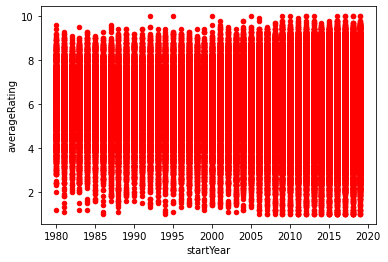

In [ ]:
rated.plot(x="startYear", y="averageRating", kind="scatter", color="r")

In [ ]:
rated = rated.groupby("startYear").mean()

In [ ]:
final = rated.head(52)

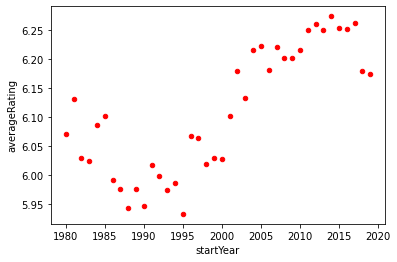

In [ ]:
final = pd.DataFrame(final).reset_index()
final.plot(x="startYear", y="averageRating", kind="scatter", color="r")

In [ ]:
final.to_csv("Average Movie Ratings.csv")

In [ ]:
# Visualization
'''
Want

		1-How does economic growth affect the overall supply of the cinema entertainment?
			-Plot GDP per capita, Consumer Sentiment, unemployment rate, movie releases:
				-We got the movie releases (=box_office_qrt) graph
				-We got the gdp_capita graph
				-We got the consumer_sent graph
				-We got the consumer_sent graph
					-Problems:
						-Merged column shows data from 1990, but we want it from 1980
						-GDP_per_capita has larger with respect to unemployment_rate and consumer sentiment. Thus, it needs to be plotted in a different graph
						-I cannot merge the df from box_office_qrt with data_qrt because on “Date” because the the quarters are measured differently
		1.1-How does economic growth affect the overall supply of the cinema entertainment?
			-Plot GDP per capita, Consumer Sentiment, unemployment rate, tickets sold per year quarter
		2-How does it shift the respective market shares of different genres? Doe
		3-Do other externa factors besides the state of the economy have more explanatory power concerning supply and demand?--> here we could look at netflix.
		4-Consumer confidence increased. *Key indicator to evaluate*
'''

'\nWant\n\n\t\t1-How does economic growth affect the overall supply of the cinema entertainment?\n\t\t\t-Plot GDP per capita, Consumer Sentiment, unemployment rate, movie releases:\n\t\t\t\t-We got the movie releases (=box_office_qrt) graph\n\t\t\t\t-We got the gdp_capita graph\n\t\t\t\t-We got the consumer_sent graph\n\t\t\t\t-We got the consumer_sent graph\n\t\t1.1-How does economic growth affect the overall supply of the cinema entertainment?\n\t\t\t-Plot GDP per capita, Consumer Sentiment, unemployment rate, tickets sold per year quarter\n\t\t2-How does it shift the respective market shares of different genres?\n\t\t3-Do other externa factors besides the state of the economy have more explanatory power concerning supply and demand?--> here we could look at netflix.\n\t\t4-Consumer confidence increased. *Key indicator to evaluate*\n'

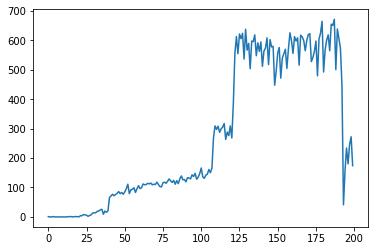

In [ ]:
plt.plot(box_office_qrt.Releases)

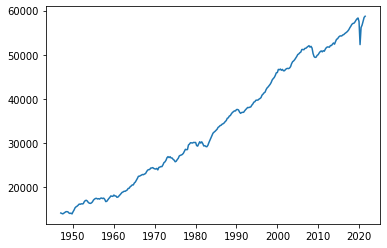

In [ ]:
plt.plot(gdp_capita.Date, gdp_capita.gdp_per_capita)

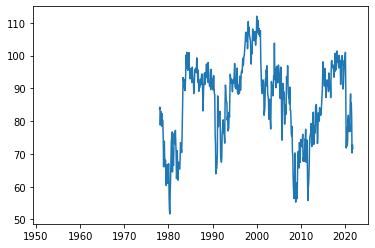

In [ ]:
plt.plot(consumer_sent.Date, consumer_sent.consum_sent)

In [ ]:
data_qrt.head(10)

,Date,gas_price,UNRATE,consum_sent,GDP,gdp_per_capita,PCE,debt_pct_income,Releases,gross
0,1990-01-01,NaN,5.300000,91.266667,9364.259,37617.0,0.62198,11.649150,110,1.479302e+09
1,1990-04-01,NaN,5.333333,90.933333,9398.243,37636.0,0.62764,11.600660,103,1.709974e+09
2,1990-07-01,1.947705,5.700000,79.133333,9404.494,37529.0,0.63562,11.583131,102,2.047944e+09
3,1990-10-01,2.070536,6.133333,65.133333,9318.876,37056.0,0.64402,11.604449,116,1.602071e+09
4,1991-01-01,1.706441,6.600000,74.966667,9275.276,36769.0,0.64740,11.578032,118,1.806037e+09
5,1991-04-01,1.705381,6.833333,80.733333,9347.597,36938.0,0.65092,11.434237,114,1.443730e+09
6,1991-07-01,1.688488,6.866667,82.633333,9394.834,36993.0,0.65533,11.318681,121,1.870961e+09
7,1991-10-01,1.647881,7.100000,71.866667,9427.581,36995.0,0.66008,11.117333,129,1.516476e+09
8,1992-01-01,1.525923,7.366667,70.766667,9540.444,37328.0,0.66421,10.855581,122,1.629860e+09
9,1992-04-01,1.647074,7.600000,78.933333,9643.893,37607.0,0.66862,10.680886,117,1.683190e+09


In [ ]:
# plt.plot(data_qrt.Date, data_qrt.UNRATE, data_qrt.Date)

In [ ]:
box_office_qrt_Datex = box_office_qrt.set_index('Date')
box_office_qrt_Datex.head()

,Releases,gross
Date,,
1972-01-01,1,133698921
1972-04-01,0,0
1972-07-01,0,0
1972-10-01,1,84563118
1973-01-01,0,0


In [ ]:
box_office_qrt_Datex_pct = box_office_qrt_Datex.pct_change()
box_office_qrt_Datex_pct.head()

,Releases,gross
Date,,
1972-01-01,NaN,NaN
1972-04-01,-1.0,-1.0
1972-07-01,NaN,NaN
1972-10-01,inf,inf
1973-01-01,-1.0,-1.0


In [ ]:
# supply = data_qrt.merge(box_office_qrt_reset, on="Date", how="outer")
'''
It returns an error because thee quarter dates are different
''' 

'\nIt returns an error because thee quarter dates are different\n'

In [ ]:
data_qrt_Datex = data_qrt.set_index('Date')
data_qrt_Datex_pct = data_qrt_Datex.pct_change()
data_qrt_Datex_pct.head()

,gas_price,UNRATE,consum_sent,GDP,gdp_per_capita,PCE,debt_pct_income,Releases,gross
Date,,,,,,,,,
1990-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-04-01,NaN,0.006289,-0.003652,0.003629,0.000505,0.009100,-0.004163,-0.063636,0.155933
1990-07-01,NaN,0.068750,-0.129765,0.000665,-0.002843,0.012714,-0.001511,-0.009709,0.197647
1990-10-01,0.063065,0.076023,-0.176917,-0.009104,-0.012604,0.013215,0.001840,0.137255,-0.217717
1991-01-01,-0.175846,0.076087,0.150972,-0.004679,-0.007745,0.005248,-0.002276,0.017241,0.127314


In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pylab as plt

In [ ]:
'''
fig, axes = plt.subplot(nrows=1, ncols=3, figsize=(15,5))

data_qrt_Datex['gdp_per_capita'].plot(ax = axes[0])
data_qrt_Datex['UNRATE'].plot(ax = axes[1])
data_qrt_Datex['consum_sent'].plot(ax = axes[2])
'''

"\nfig, axes = plt.subplot(nrows=1, ncols=3, figsize=(15,5))\n\ndata_qrt_Datex['gdp_per_capita'].plot(ax = axes[0])\ndata_qrt_Datex['UNRATE'].plot(ax = axes[1])\ndata_qrt_Datex['consum_sent'].plot(ax = axes[2])\n"

In [ ]:
# Plot for the econoomic conditions with percentage change on the y-axis
data_qrt_Datex_pct[['UNRATE', 'consum_sent']].plot(color = ('r','y'), figsize = (8, 4))
plt.axvline(x = '1992-01-01', color = 'c', label = 'Recession 1', linestyle = 'dotted')
plt.axvline(x = '1992-04-01', color = 'y', label = 'Recession 2', linestyle = 'dotted')
plt.legend(loc = 5, prop = {'size': 10})

data_qrt_Datex_pct[['gdp_per_capita']].plot(figsize = (8, 4))
plt.axvline(x = '1992-01-01', color = 'c', label = 'Recession 1', linestyle = 'dotted')
plt.axvline(x = '1992-04-01', color = 'y', label = 'Recession 2', linestyle = 'dotted')
plt.legend(loc = 5, prop = {'size': 10})

box_office_qrt_Datex_pct[['Releases']].plot(color = ('c'), figsize = (8, 4))
plt.axvline(x = ('1992-01-01'), color = 'c', label = 'Recession 1', linestyle = 'dotted')
plt.axvline(x = '1992-04-01', color = 'y', label = 'Recession 2', linestyle = 'dotted')
plt.legend(loc = 5, prop = {'size': 10})

plt.show()

NameError: name 'data_qrt_Datex_pct' is not defined

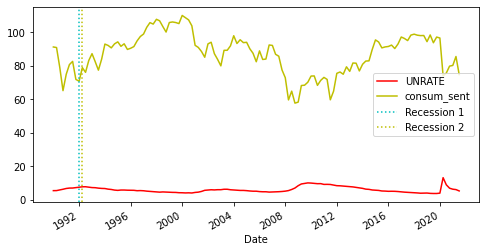

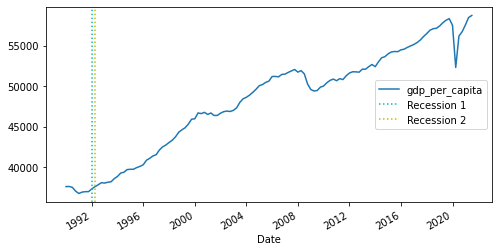

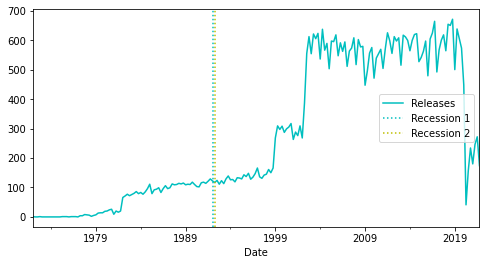

In [ ]:
# Plot for the econoomic conditions with percentage change on the y-axis
data_qrt_Datex[['UNRATE', 'consum_sent']].plot(color = ('r','y'), figsize = (8, 4))
plt.axvline(x = '1992-01-01', color = 'c', label = 'Recession 1', linestyle = 'dotted')
plt.axvline(x = '1992-04-01', color = 'y', label = 'Recession 2', linestyle = 'dotted')
plt.legend(loc = 5, prop = {'size': 10})

data_qrt_Datex[['gdp_per_capita']].plot(figsize = (8, 4))
plt.axvline(x = '1992-01-01', color = 'c', label = 'Recession 1', linestyle = 'dotted')
plt.axvline(x = '1992-04-01', color = 'y', label = 'Recession 2', linestyle = 'dotted')
plt.legend(loc = 5, prop = {'size': 10})

box_office_qrt_Datex[['Releases']].plot(color = ('c'), figsize = (8, 4))
plt.axvline(x = ('1992-01-01'), color = 'c', label = 'Recession 1', linestyle = 'dotted')
plt.axvline(x = '1992-04-01', color = 'y', label = 'Recession 2', linestyle = 'dotted')
plt.legend(loc = 5, prop = {'size': 10})
plt.show()